In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-07-25 19:19:11--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   130MB/s    in 6.1s    

2020-07-25 19:19:18 (130 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:


def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu' , input_shape = (150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [8]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
TRAINING_DIR = "/tmp/cats-v-dogs/training"
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range = 40,
                                   shear_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size = (150,150),
                                                    batch_size=128,
                                                    class_mode='binary')

VALIDATION_DIR = "/tmp/cats-v-dogs/testing"
validation_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range = 40,
                                   shear_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    target_size = (150,150),
                                                    batch_size=128,
                                                    class_mode='binary')



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=25,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8
)

Epoch 1/25
8/8 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.6660

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

8/8 [==============================] - 17s 2s/step - loss: 0.6062 - accuracy: 0.6660 - val_loss: 0.5642 - val_accuracy: 0.7197
Epoch 2/25
8/8 [==============================] - 17s 2s/step - loss: 0.5912 - accuracy: 0.6855 - val_loss: 0.5900 - val_accuracy: 0.6924
Epoch 3/25
8/8 [==============================] - 17s 2s/step - loss: 0.6237 - accuracy: 0.6543 - val_loss: 0.5745 - val_accuracy: 0.6807
Epoch 4/25
8/8 [==============================] - 17s 2s/step - loss: 0.6142 - accuracy: 0.6660 - val_loss: 0.5757 - val_accuracy: 0.6885
Epoch 5/25
8/8 [==============================] - 17s 2s/step - loss: 0.6053 - accuracy: 0.6865 - val_loss: 0.5731 - val_accuracy: 0.6992
Epoch 6/25
8/8 [==============================] - 17s 2s/step - loss: 0.5827 - accuracy: 0.6680 - val_loss: 0.8918 - val_accuracy: 0.5771
Epoch 7/25
8/8 [==============================] - 17s 2s/step - loss: 0.6709 - accuracy: 0.6494 - val_loss: 0.5679 - val_accuracy: 0.7051
Epoch 8/25
8/8 [=============================

Text(0.5, 1.0, 'Training and validation loss')

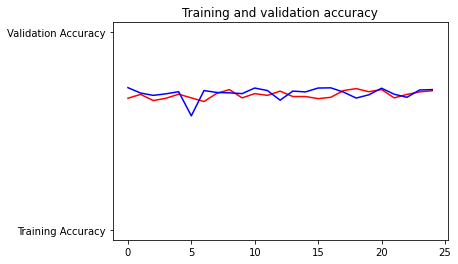

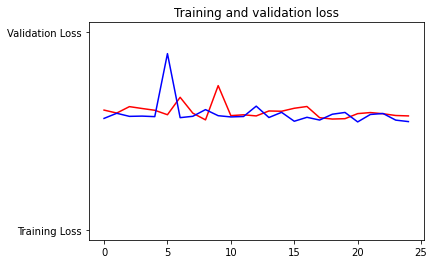

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')
